In [1]:
import hydra
from glob import  glob
from rosa.data import  RosaDataModule, create_io_paths
from rosa.modeling import  RosaLightningModule


BASE_DIR = "/home/ec2-user/rosa/conf/" # /Users/nsofroniew/Documents/GitHub/ or /home/ec2-user/

with hydra.initialize_config_dir(config_dir=BASE_DIR):
    config = hydra.compose(config_name="config")
    config.paths.base = '/home/ec2-user/cell_census' # '/Users/nsofroniew/Documents/data/multiomics/cell_census'

    _, output_path = create_io_paths(config.paths)

    # config.data_module.data.mask = 0.01
    # config.data_module.data.n_var_sample = 1000
    # Create Data Module
    rdm = RosaDataModule(
        output_path,
        config=config.data_module,
    )
    rdm.setup()

    adata = rdm.val_dataset.adata
    obs_indices = rdm.val_dataset.obs_indices.detach().numpy()
    var_bool = rdm.val_dataset.mask_bool.detach().numpy()
    adata_predict = adata[obs_indices, var_bool]
    
    rlm = RosaLightningModule(
        var_input=rdm.var_input,
        config=config.module,
        adata=adata_predict,
    )
    print(rlm)
    print(output_path)

/tmp/ipykernel_19121/2318672697.py:9: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with hydra.initialize_config_dir(config_dir=BASE_DIR):
/opt/conda/envs/pytorch/lib/python3.9/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'config': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)
/opt/conda/envs/pytorch/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


RosaLightningModule(
  (model): RosaTransformer(
    (expression_embedding): BinnedEmbed(
      (model): Sequential(
        (embedding): Embedding(9, 128)
        (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
    )
    (var_embedding): Sequential(
      (layer_norm_1): LayerNorm((3072,), eps=1e-05, elementwise_affine=True)
      (input_embed_1): InputEmbed(
        (model): Sequential(
          (projection): Linear(in_features=3072, out_features=128, bias=True)
          (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.2, inplace=False)
        )
      )
    )
    (transformer): Performer(
      (net): SequentialSequence(
        (layers): ModuleList(
          (0): ModuleList(
            (0): PreLayerNorm(
              (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
              (fn): SelfAttention(
                (fast_attention): Fast

In [2]:
# rdm.val_dataset.transform(rdm.val_dataset.expression[0]).min()
rdm.val_dataset[0]

{'expression_input': tensor([1, 8, 8,  ..., 0, 0, 8]),
 'expression_target': tensor([1, 0, 1,  ..., 0, 0, 0]),
 'mask': tensor([False,  True,  True,  ..., False, False,  True]),
 'var_indices': tensor([    0,     1,     2,  ..., 19428, 19429, 19430]),
 'obs_idx': tensor(4)}

In [3]:
item = rdm.val_dataset[0]
print(item['mask'].sum())
print(len(item['mask']))

tensor(5792)
19431


In [4]:
item = rdm.train_dataset[0]
print(item['mask'].sum())
print(len(item['mask']))

tensor(2727)
13639


In [5]:
from tqdm import tqdm
import torch


expression = []
expression_masked = []
mask_var = []
for item in tqdm(rdm.train_dataset):
    expression.append(item['expression_target'])
    expression_masked.append(item['expression_target'][item['mask']])
    mask_var.append(torch.where(item['mask'])[0])
expression = torch.stack(expression, dim=0)
expression_masked = torch.stack(expression_masked, dim=0)
mask_var = torch.stack(mask_var, dim=0)
values, counts = torch.unique(expression, return_counts=True)
values, counts_masked = torch.unique(expression_masked, return_counts=True)
counts_norm = counts / counts.sum()
counts_masked_norm = counts_masked / counts_masked.sum()

100%|██████████| 272/272 [00:01<00:00, 240.14it/s]


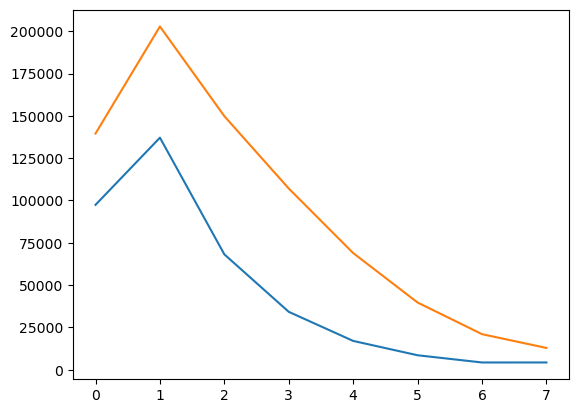

In [6]:
import matplotlib.pyplot as plt

plt.plot(counts / 1e1)
plt.plot(counts_masked)

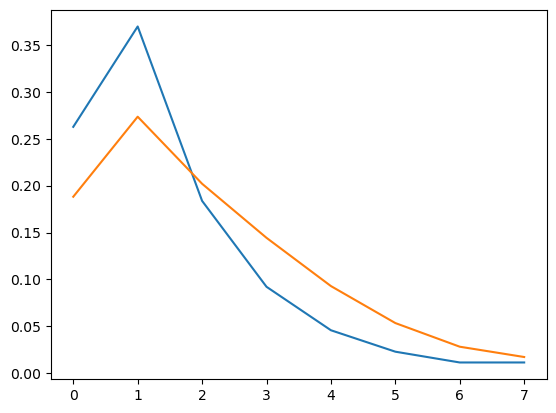

In [7]:
plt.plot(counts_norm)
plt.plot(counts_masked_norm)

In [8]:
expression_masked.shape

torch.Size([272, 2727])

In [9]:
mask_var.shape

torch.Size([272, 2727])

In [10]:
mask_freq = torch.bincount(mask_var.ravel(), minlength=expression.shape[1])

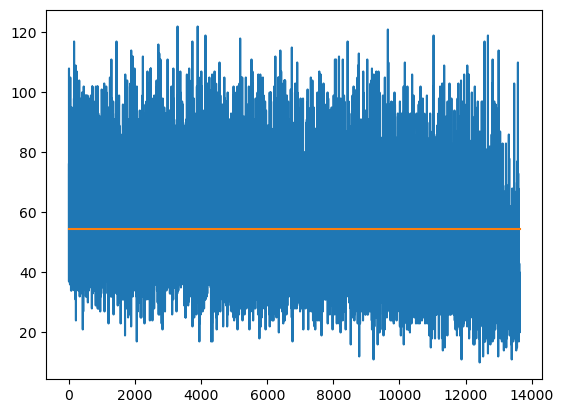

In [11]:
plt.plot(mask_freq)
val = expression.shape[0] * config.data_module.data.mask
plt.plot([0, expression.shape[1]], [val, val])

In [12]:
masked_cat = torch.stack([mask_var, expression_masked], dim=0)

In [13]:
torch.unique(masked_cat, return_counts=True, dim=0)

(tensor([[[    0,     0,     1,  ...,     0,     1,     0],
          [    1,     3,     1,  ...,     1,     0,     1],
          [    2,     2,     3,  ...,     0,     0,     0],
          ...,
          [    2,     2,     1,  ...,     1,     0,     1],
          [    4,     1,     3,  ...,     0,     0,     0],
          [    4,     3,     1,  ...,     1,     0,     0]],
 
         [[    4,     9,    13,  ..., 13614, 13628, 13630],
          [    3,     5,     9,  ..., 13622, 13626, 13636],
          [    1,     7,    14,  ..., 13617, 13623, 13631],
          ...,
          [    7,     8,    11,  ..., 13619, 13622, 13635],
          [    0,     1,     4,  ..., 13626, 13628, 13633],
          [    4,    10,    16,  ..., 13608, 13609, 13628]]]),
 tensor([1, 1]))

In [14]:
n_var = expression.shape[1]
n_bins = 8
# rows, cols = torch.arange(n_var)[:, None, None, None], torch.arange(n_bins)[:, None, None]

# # Add extra dimensions to A and B for broadcasting
# A_exp = mask_var[None, None, :, :]
# B_exp = expression_masked[None, None, :, :]

# # Count occurrences using broadcasting and advanced indexing
# C = torch.sum((A_exp == rows) & (B_exp == cols), dim=(-1, -2)).T

N = n_var
M = n_bins
# Flatten A and B, and calculate the linear indices for the bincount operation
A_flat = mask_var.view(-1)
B_flat = expression_masked.view(-1)
linear_indices = A_flat * M + B_flat

# Count occurrences using bincount and reshape the result to the desired shape
counts = torch.bincount(linear_indices, minlength=N * M)
C = counts.view(N, M)


In [15]:
C.sum(dim=0)

tensor([139555, 202816, 149808, 107072,  68934,  39697,  21001,  12861])

In [16]:
counts_masked

tensor([139555, 202816, 149808, 107072,  68934,  39697,  21001,  12861])

In [17]:
counts = torch.stack([torch.bincount(x, minlength=8) for x in expression.T])

In [25]:
counts[3]

tensor([ 37, 131,  36,  22,  18,  11,   8,   9])

In [28]:
C[3]

tensor([19, 24, 19, 12, 11,  8,  8,  7])

In [ ]:
272 *.2 / 8

In [ ]:
expression_masked.max()

In [ ]:
rdm.train_dataset.counts

In [ ]:
expression_vector = expression[0][:1000]

result = rdm.train_dataset.counts[expression_vector, torch.arange(expression_vector.shape[0])]

In [ ]:
result.shape

In [ ]:
rdm.train_dataset.counts.shape

In [ ]:
expression = []
expression_masked = []
for item in tqdm(rdm.val_dataset):
    expression.append(item['expression_target'])
    expression_masked.append(item['expression_target'][item['mask']])
expression = torch.stack(expression, dim=0)
expression_masked = torch.stack(expression_masked, dim=0)
values, counts = torch.unique(expression, return_counts=True)
values, counts_masked = torch.unique(expression_masked, return_counts=True)
counts_norm = counts / counts.sum()
counts_masked_norm = counts_masked / counts_masked.sum()

In [ ]:
plt.plot(counts / 1e2)
plt.plot(counts_masked)

In [ ]:
plt.plot(counts_norm)
plt.plot(counts_masked_norm)

In [ ]:
values, counts = torch.unique(expression, return_counts=True)
counts = counts / counts.sum()

In [ ]:
counts

In [ ]:
counts = torch.bincount(expression.ravel(), minlength=8)
counts / counts.sum()

In [ ]:
counts = torch.stack([torch.bincount(x, minlength=8) for x in expression.T]).T
counts = counts / expression.shape[0]

In [ ]:
inv_counts = 1 / counts

In [ ]:
expression_vector = expression[0]

In [ ]:
result = inv_counts[expression_vector, torch.arange(expression_vector.shape[0])]

In [ ]:
counts

In [ ]:
result.max()

In [ ]:
expression_vector

In [ ]:
inv_counts.T[expression_vector]

In [ ]:
expression_vector

In [ ]:
expression_vector.shape

In [ ]:
inv_counts.shape

In [ ]:
counts = counts / expression.shape[0]

In [ ]:
counts

In [ ]:
values, counts = torch.unique(expression, return_counts=True, dim=1)

In [ ]:
values.shape

In [ ]:
train_var = rdm.train_dataset.var_indices
test_var = torch.where(rdm.val_dataset.mask_bool)[0]

In [ ]:
print(torch.all(~torch.isin(train_var, test_var)))
print(torch.all(~torch.isin(test_var, train_var)))

In [ ]:
item = rdm.train_dataset[10]
print(torch.all(torch.isin(item['var_indices'], train_var)))
print(torch.all(~torch.isin(item['var_indices'], test_var)))

In [ ]:
item = rdm.train_dataset[10]
mask_var = item['var_indices'][item['mask']]
print(torch.all(torch.isin(mask_var, train_var)))
print(torch.all(~torch.isin(mask_var, test_var)))

In [ ]:
item = rdm.val_dataset[10]
mask_var = item['var_indices'][item['mask']]
print(torch.all(~torch.isin(mask_var, train_var)))
print(torch.all(torch.isin(mask_var, test_var)))

#### Look at predict dataset

In [ ]:
item = rdm.predict_dataset[0]
print(item['mask'].sum())
print(len(item['mask']))

In [ ]:
item = rdm.predict_dataset[10]
mask_var = item['var_indices'][item['mask']]
print(torch.all(~torch.isin(mask_var, train_var)))
print(torch.all(torch.isin(mask_var, test_var)))
print(torch.all(torch.isin(test_var, mask_var)))

In [ ]:
expression = []
expression_masked = []
for item in tqdm(rdm.predict_dataset):
    expression.append(item['expression_target'])
    expression_masked.append(item['expression_target'][item['mask']])
expression = torch.stack(expression, dim=0)
expression_masked = torch.stack(expression_masked, dim=0)
values, counts = torch.unique(expression, return_counts=True)
values, counts_masked = torch.unique(expression_masked, return_counts=True)
counts = counts / counts.sum()
counts_masked = counts_masked / counts_masked.sum()

In [ ]:
plt.plot(counts)
plt.plot(counts_masked)

## Binning

In [ ]:
import torch

In [ ]:
torch.unique(rdm.val_dataset[0]['expression_target'], return_counts=True)

In [ ]:
rdm.val_dataset[0]

In [ ]:
tensor = torch.Tensor(rdm.val_dataset.expression[4])

In [ ]:
import numpy as np

In [ ]:
val, counts = torch.unique(tensor, return_counts=True)

In [ ]:
n_bins = 16

In [ ]:
# Put all zero values in their own bin and then distribute others evenly
boundaries = torch.quantile(tensor[tensor>0], torch.linspace(0, 1, n_bins))
boundaries = torch.concat([torch.tensor([0]), boundaries])
boundaries[-1] = torch.inf
aa = torch.bucketize(tensor, boundaries, right=True) - 1
torch.unique(aa, return_counts=True)

In [ ]:
# Put all zero values in their own bin and then distribute others evenly
boundaries = torch.quantile(tensor, torch.linspace(0, 1, n_bins))
ab = torch.bucketize(tensor, boundaries)
torch.unique(ab, return_counts=True)

In [ ]:
boundaries = torch.quantile(tensor[tensor>0], torch.linspace(0, 1, n_bins - 1))
tmp = torch.bucketize(tensor[tensor>0], boundaries) + 1
new = torch.zeros_like(tensor).long()
new[tensor > 0] = tmp
torch.unique(new, return_counts=True)

In [ ]:
torch.quantile(tensor, torch.linspace(0, 1, n_bins))

In [ ]:
torch.unique(aa, return_counts=True)

In [ ]:
boundaries

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.bar(val, counts)
plt.ylim([0, 50]);

In [ ]:
torch.quantile(tensor, torch.linspace(0, 1, n_bins))

In [ ]:
torch.quantile(tensor, torch.logspace(0, .301, n_bins) - 1)

In [ ]:
torch.logspace(0, .301, n_bins) - 1

In [ ]:
10**2

In [ ]:
from rosa.utils import score_predictions, plot_expression_and_correlation, plot_marker_gene_heatmap


adata_test, results = score_predictions(adata)

In [ ]:
plot_expression_and_correlation(adata_test, results)

In [ ]:
import numpy as np


marker_genes = adata_test.var[adata_test.var['highly_variable']]['feature_name'].values
np.random.seed(42)
marker_genes = np.random.choice(marker_genes, 50)

plot_marker_gene_heatmap(adata_test, marker_genes)

In [ ]:
marker_genes_dict = adata_test.obs.set_index('label').to_dict()['marker_feature_name']
plot_marker_gene_heatmap(adata_test, marker_genes_dict)